# **Sentiment Analysis on Movie Reviews with PySpark**

# **1. Project Description**

- This project aims to develop and evaluate Machine Learning models for sentiment classification (positive or negative) based on the text of movie reviews. The dataset used is the "IMDb reviews in Portuguese do Brasil," which contains reviews in Portuguese and their English translations.

- The analysis and modeling were performed using the Apache Spark ecosystem, specifically the PySpark library, which is ideal for large-scale data processing. Three different classification algorithms were explored, trained, and optimized: **Decision Tree**, **Random Forest**, and **XGBoost**.

# **2. Project Structure**

The project workflow, as executed in the notebook, follows these steps:

## **2.1. Environment Setup**

Installation of the necessary libraries for distributed processing and modeling, including:
- pyspark: To use Apache Spark with Python.
- xgboost: For the Gradient Boosting model.

In [136]:
!pip install pyspark

In [137]:
!pip install xgboost

In [138]:
# Libraries installed
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import pyspark.sql.functions as f
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import IntegerType
import nltk
from nltk.corpus import stopwords
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, HashingTF, IDF,  StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from xgboost.spark.estimator import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import IndexToString

In [139]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [140]:
# Starting Spark
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

## **2.2. Data Loading and Exploratory Data Analysis (EDA)**

- **Loading:** Data was loaded from the imdb-reviews-pt-br.csv file into a Spark DataFrame.

- **Initial Exploration:**

  - Checking the total number of records.

  - Analyzing the distribution of sentiment classes (pos vs. neg), which revealed an **imbalance**, with more negative reviews than positive ones.

  - Visualizing sample texts to understand the data structure.

- **Visualization**: A **Word Cloud** was generated to visually identify the most frequent terms in the review corpus.

In [141]:
datas = spark.read.csv("/content/imdb-reviews-pt-br.csv",
                       escape = '\"',
                       inferSchema=True,
                       header = True)

In [142]:
datas.count()

49459

In [143]:
print("Positive")
datas.filter(datas.id == 12427).select("text_en").show(truncate = False)

Positive
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_en                                                                                                                                                                                                                                                      

In [144]:
print("Negative")
datas.filter(datas.id == 190).select("text_en").show(truncate = False)

Negative
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_en                                                                                                                                        

In [145]:
datas.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [146]:
datas_clean = datas.na.drop(subset=['text_pt']) \
                     .na.drop(subset=['text_en']) \
                     .na.drop(subset=['sentiment'])

In [147]:
datas_clean.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [148]:
sample = datas_clean.select('text_en').sample(fraction = 0.1, seed = 101)
all = [text['text_en'] for text in sample.collect()]

In [149]:
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False,
                      prefer_horizontal = 1).generate(str(all))

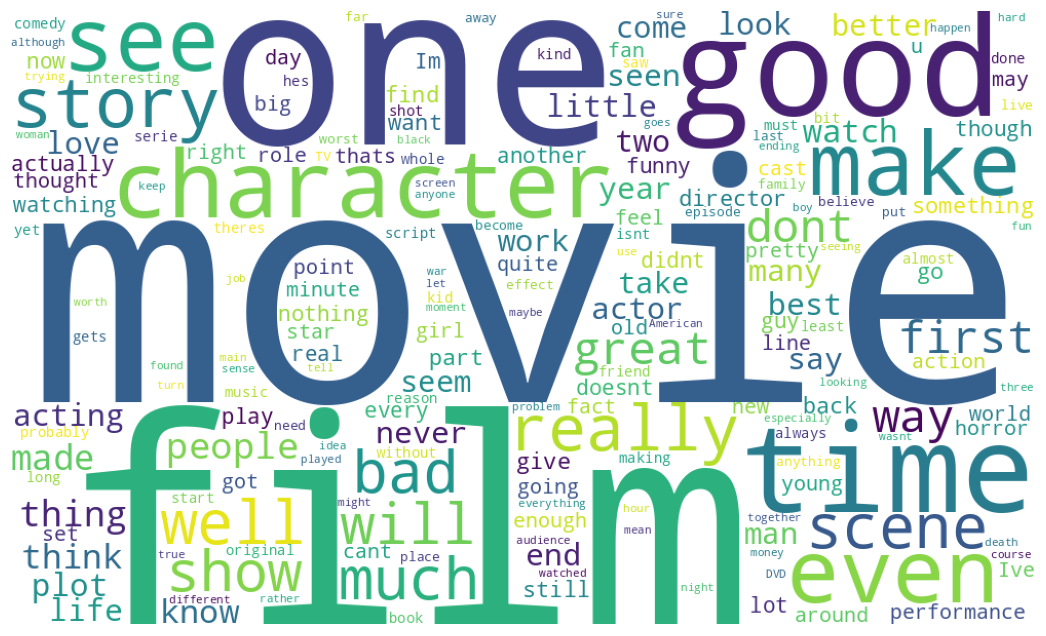

In [150]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **2.3. Data Pre-processing and Feature Engineering**

To prepare the text data for the Machine Learning models, a pipeline was built with the following stages:



1.   **Text Cleaning:** Removal of punctuation, special characters, and symbols using regular expressions (regexp_replace).
2.   **Label Creation:** Conversion of the categorical sentiment column ('pos', 'neg') into a numeric label column using StringIndexer. The 'neg' class was mapped to 0.0 and 'pos' to 1.0.
3.   **Tokenization:** Splitting the cleaned text into individual words (tokens) with the Tokenizer.
4.   Stop Words Removal: Exclusion of common English words (like "the", "a", "is") that do not add value to sentiment analysis, using StopWordsRemover.
5.   **Vectorization (TF-IDF):**
- **HashingTF:** Conversion of the list of tokens into feature vectors by calculating the frequency of each term (Term Frequency).
- **IDF (Inverse Document Frequency):** Application of the IDF weight to the vectors to give more importance to words that are rare in the corpus and less importance to those that are very frequent. The final features column is generated in this step.

In [151]:
datas_clean = datas_clean.withColumn("text_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

datas_clean.limit(2).show(truncate = False)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2574329572.py:1: SyntaxWarning: invalid escape sequence '\$'
  datas_clean = datas_clean.withColumn("text_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))


+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [152]:
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")

In [153]:
# Célula 18 (Código Corrigido e Final)

# Treina o modelo StringIndexer UMA ÚNICA VEZ e o salva em uma nova variável
print("Fitting StringIndexer model...")
stringindexer_model = stringindexer.fit(datas_clean)

# Usa o modelo treinado para transformar o DataFrame e adicionar a coluna 'label'
print("Transforming DataFrame to add 'label' column...")
datas_clean = stringindexer_model.transform(datas_clean)

print("Done. The 'stringindexer_model' is now saved.")

Fitting StringIndexer model...
Transforming DataFrame to add 'label' column...
Done. The 'stringindexer_model' is now saved.


In [154]:
datas_clean.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [155]:
datas_clean = datas_clean.withColumn("text_clean", f.trim(datas_clean.text_regex))

In [156]:
stop_words = stopwords.words("english")

In [157]:
tokenizer = Tokenizer(inputCol = "text_clean", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

In [158]:
pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [159]:
transformed_datas = pipeline.fit(datas_clean).transform(datas_clean)

In [160]:
tokenizer = Tokenizer(inputCol = "text_clean", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

In [161]:
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label')
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
xgb = SparkXGBClassifier(features_col='features', label_col='label')

In [162]:
# Define the models to be tested
pipeline_dtc = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dtc])
pipeline_rf = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, rf])
pipeline_xgb = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, xgb])

In [163]:
SEED = 101

## **2.4. Data Splitting**

The dataset was randomly split into **training (70%)** and **testing (30%)** sets to allow for model training and evaluation.

In [164]:
train, test = datas_clean.randomSplit([0.7, 0.3], seed = SEED)

# **3. Modeling and Optimization**

## **3.1. Base Models**

**Decision Tree Classifier Model**

In [165]:
dt_model = pipeline_dtc.fit(train)

In [166]:
predictions_dt_train = dt_model.transform(train)

In [167]:
predictions_dt_test = dt_model.transform(test)

In [168]:
predictions_dt_test.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



**Random Forest Classifier Model**

In [169]:
rf_model = pipeline_rf.fit(train)

In [170]:
predictions_rf_train = rf_model.transform(train)

In [171]:
predictions_rf_test = rf_model.transform(test)

In [172]:
predictions_rf_test.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



**XGBoosting Classifier Model**

In [173]:
xgb_model = pipeline_xgb.fit(train)

INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [174]:
predictions_xgb_train = xgb_model.transform(train)

In [175]:
predictions_xgb_test = xgb_model.transform(test)

In [176]:
predictions_xgb_test.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



## **3.1. Base Models Evaluation**

In [177]:
# Evaluator for multiple metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# --- Decision Tree Classifier ---
print("="*40)
print("Decision Tree Classifier Metrics")
print("="*40)

# Confusion Matrix
print("Confusion Matrix:")
predictions_dt_test.groupBy("label", "prediction").count().show()

# Evaluation Metrics
accuracy_dt = evaluator.evaluate(predictions_dt_test, {evaluator.metricName: "accuracy"})
precision_dt = evaluator.evaluate(predictions_dt_test, {evaluator.metricName: "weightedPrecision"})
recall_dt = evaluator.evaluate(predictions_dt_test, {evaluator.metricName: "weightedRecall"})
f1_dt = evaluator.evaluate(predictions_dt_test, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}")
print("\n")


# --- Random Forest Classifier ---
print("="*40)
print("Random Forest Classifier Metrics")
print("="*40)

# Confusion Matrix
print("Confusion Matrix:")
predictions_rf_test.groupBy("label", "prediction").count().show()

# Evaluation Metrics
accuracy_rf = evaluator.evaluate(predictions_rf_test, {evaluator.metricName: "accuracy"})
precision_rf = evaluator.evaluate(predictions_rf_test, {evaluator.metricName: "weightedPrecision"})
recall_rf = evaluator.evaluate(predictions_rf_test, {evaluator.metricName: "weightedRecall"})
f1_rf = evaluator.evaluate(predictions_rf_test, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print("\n")

# --- XGBoost Classifier ---
print("="*40)
print("XGBoost Classifier Metrics")
print("="*40)

# Confusion Matrix
print("Confusion Matrix:")
predictions_xgb_test.groupBy("label", "prediction").count().show()

# Evaluation Metrics
accuracy_xgb = evaluator.evaluate(predictions_xgb_test, {evaluator.metricName: "accuracy"})
precision_xgb = evaluator.evaluate(predictions_xgb_test, {evaluator.metricName: "weightedPrecision"})
recall_xgb = evaluator.evaluate(predictions_xgb_test, {evaluator.metricName: "weightedRecall"})
f1_xgb = evaluator.evaluate(predictions_xgb_test, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print("\n")

Decision Tree Classifier Metrics
Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5780|
|  0.0|       1.0| 3569|
|  1.0|       0.0| 1527|
|  0.0|       0.0| 3944|
+-----+----------+-----+

Accuracy: 0.6561
Precision: 0.6703
Recall: 0.6561
F1-Score: 0.6502


Random Forest Classifier Metrics
Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5696|
|  0.0|       1.0| 2507|
|  1.0|       0.0| 1611|
|  0.0|       0.0| 5006|
+-----+----------+-----+

Accuracy: 0.7221
Precision: 0.7259
Recall: 0.7221
F1-Score: 0.7213


XGBoost Classifier Metrics
Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5780|
|  0.0|       1.0| 1658|
|  1.0|       0.0| 1527|
|  0.0|       0.0| 5855|
+-----+----------+-----+

Accuracy: 0.7851
Precision: 0.7852
Recall: 0.7851
F1-Score: 0.7851




# **4.  Hyperparameter Tuning**

## **4.1.  Tuned Models**

In [178]:
# Evaluator to be used by the CrossValidator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


In [179]:
# --- Decision Tree Classifier Optimization ---
print("="*40)
print("Optimizing Decision Tree Classifier...")
print("="*40)

# Define the grid of parameters to be tested
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [2, 5, 10]) \
    .addGrid(dtc.maxBins, [10, 20, 40]) \
    .build()

Optimizing Decision Tree Classifier...


In [180]:
# Set up the CrossValidator
cv_dt = CrossValidator(estimator=pipeline_dtc,
                       estimatorParamMaps=paramGrid_dt,
                       evaluator=evaluator,
                       numFolds=3)

In [181]:
# Train the model using Cross-Validation to find the best hyperparameters
cvModel_dt = cv_dt.fit(train)

In [182]:
# Make predictions on the test set with the best model found
predictions_dt_tuned = cvModel_dt.transform(test)

In [183]:
# Evaluate the tuned model
print("Tuned Decision Tree Metrics:")
predictions_dt_tuned.groupBy("label", "prediction").count().show()
accuracy_dt_tuned = evaluator.evaluate(predictions_dt_tuned)
print(f"Tuned Model Accuracy: {accuracy_dt_tuned:.4f}\n")

Tuned Decision Tree Metrics:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5297|
|  0.0|       1.0| 2844|
|  1.0|       0.0| 2010|
|  0.0|       0.0| 4669|
+-----+----------+-----+

Tuned Model Accuracy: 0.6725



In [184]:
# --- Random Forest Classifier Optimization ---
print("="*40)
print("Optimizing Random Forest Classifier...")
print("="*40)

# Define the parameter grid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .build()

Optimizing Random Forest Classifier...


In [185]:
# Set up the CrossValidator
cv_rf = CrossValidator(estimator=pipeline_rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator,
                       numFolds=3)

In [186]:
# Train the model
cvModel_rf = cv_rf.fit(train)

In [187]:
# Make predictions
predictions_rf_tuned = cvModel_rf.transform(test)

In [188]:
# Evaluate the tuned model
print("Tuned Random Forest Metrics:")
predictions_rf_tuned.groupBy("label", "prediction").count().show()
accuracy_rf_tuned = evaluator.evaluate(predictions_rf_tuned)
print(f"Tuned Model Accuracy: {accuracy_rf_tuned:.4f}\n")

Tuned Random Forest Metrics:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5671|
|  0.0|       1.0| 2124|
|  1.0|       0.0| 1636|
|  0.0|       0.0| 5389|
+-----+----------+-----+

Tuned Model Accuracy: 0.7463



In [189]:
# --- XGBoost Classifier Optimization ---
print("="*40)
print("Optimizing XGBoost Classifier...")
print("="*40)

# Define the parameter grid
paramGrid_xgb = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [2, 4, 6]) \
    .addGrid(xgb.n_estimators, [10, 50, 100]) \
    .build()

Optimizing XGBoost Classifier...


In [190]:
# Set up the CrossValidator
cv_xgb = CrossValidator(estimator=pipeline_xgb,
                        estimatorParamMaps=paramGrid_xgb,
                        evaluator=evaluator,
                        numFolds=3)

In [191]:
# Train the model
cvModel_xgb = cv_xgb.fit(train)

INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpa

In [192]:
# Make predictions
predictions_xgb_tuned = cvModel_xgb.transform(test)

In [193]:
# Evaluate the tuned model
print("Tuned XGBoost Metrics:")
predictions_xgb_tuned.groupBy("label", "prediction").count().show()
accuracy_xgb_tuned = evaluator.evaluate(predictions_xgb_tuned)
print(f"Tuned Model Accuracy: {accuracy_xgb_tuned:.4f}\n")

Tuned XGBoost Metrics:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5812|
|  0.0|       1.0| 1735|
|  1.0|       0.0| 1495|
|  0.0|       0.0| 5778|
+-----+----------+-----+

Tuned Model Accuracy: 0.7821



In [194]:
# Evaluator for multiple metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

## **4.2. Tuned Models Evaluation**

In [195]:


# Tuned Decision Tree Classifier
print("="*40)
print("Tuned Decision Tree Classifier Metrics")
print("="*40)

# Confusion Matrix
print("Confusion Matrix:")
predictions_dt_tuned.groupBy("label", "prediction").count().show()

# Evaluation Metrics
accuracy_dt_tuned = evaluator.evaluate(predictions_dt_tuned, {evaluator.metricName: "accuracy"})
precision_dt_tuned = evaluator.evaluate(predictions_dt_tuned, {evaluator.metricName: "weightedPrecision"})
recall_dt_tuned = evaluator.evaluate(predictions_dt_tuned, {evaluator.metricName: "weightedRecall"})
f1_dt_tuned = evaluator.evaluate(predictions_dt_tuned, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy_dt_tuned:.4f}")
print(f"Precision: {precision_dt_tuned:.4f}")
print(f"Recall: {recall_dt_tuned:.4f}")
print(f"F1-Score: {f1_dt_tuned:.4f}")
print("\n")


# Tuned Random Forest Classifier
print("="*40)
print("Tuned Random Forest Classifier Metrics")
print("="*40)

# Confusion Matrix
print("Confusion Matrix:")
predictions_rf_tuned.groupBy("label", "prediction").count().show()

# Evaluation Metrics
accuracy_rf_tuned = evaluator.evaluate(predictions_rf_tuned, {evaluator.metricName: "accuracy"})
precision_rf_tuned = evaluator.evaluate(predictions_rf_tuned, {evaluator.metricName: "weightedPrecision"})
recall_rf_tuned = evaluator.evaluate(predictions_rf_tuned, {evaluator.metricName: "weightedRecall"})
f1_rf_tuned = evaluator.evaluate(predictions_rf_tuned, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy_rf_tuned:.4f}")
print(f"Precision: {precision_rf_tuned:.4f}")
print(f"Recall: {recall_rf_tuned:.4f}")
print(f"F1-Score: {f1_rf_tuned:.4f}")
print("\n")

# Tuned XGBoost Classifier
print("="*40)
print("Tuned XGBoost Classifier Metrics")
print("="*40)

# Confusion Matrix
print("Confusion Matrix:")
predictions_xgb_tuned.groupBy("label", "prediction").count().show()

# Evaluation Metrics
accuracy_xgb_tuned = evaluator.evaluate(predictions_xgb_tuned, {evaluator.metricName: "accuracy"})
precision_xgb_tuned = evaluator.evaluate(predictions_xgb_tuned, {evaluator.metricName: "weightedPrecision"})
recall_xgb_tuned = evaluator.evaluate(predictions_xgb_tuned, {evaluator.metricName: "weightedRecall"})
f1_xgb_tuned = evaluator.evaluate(predictions_xgb_tuned, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy_xgb_tuned:.4f}")
print(f"Precision: {precision_xgb_tuned:.4f}")
print(f"Recall: {recall_xgb_tuned:.4f}")
print(f"F1-Score: {f1_xgb_tuned:.4f}")
print("\n")

Tuned Decision Tree Classifier Metrics
Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5297|
|  0.0|       1.0| 2844|
|  1.0|       0.0| 2010|
|  0.0|       0.0| 4669|
+-----+----------+-----+

Accuracy: 0.6725
Precision: 0.6752
Recall: 0.6725
F1-Score: 0.6717


Tuned Random Forest Classifier Metrics
Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5671|
|  0.0|       1.0| 2124|
|  1.0|       0.0| 1636|
|  0.0|       0.0| 5389|
+-----+----------+-----+

Accuracy: 0.7463
Precision: 0.7476
Recall: 0.7463
F1-Score: 0.7461


Tuned XGBoost Classifier Metrics
Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5812|
|  0.0|       1.0| 1735|
|  1.0|       0.0| 1495|
|  0.0|       0.0| 5778|
+-----+----------+-----+

Accuracy: 0.7821
Precision: 0.7824
Recall: 0.7821
F1-Score: 0.7820




Based on the initial evaluation of the three baseline models and the analysis of the optimized models, the **XGBoosting classifier** clearly emerged as the best-performing model, as measured by **F1 score** (the harmonic mean of precision and recall) and **accuracy** (the percentage of correct classifications).


>  **Decision Tree Accuracy:**

**Accuracy:** 65.61% **->** 67.25%

**F1:** 65.02% **->** 67.17%


>  **Random Forest Accuracy:**

**Accuracy:** 72.21% **->** 74.63%

**F1:** 72.13% **->** 74.61%

>  **XGBoost Accuracy:**

**Accuracy:** 78.51% **->** 78.21%

**F1:** 78.51% **->** 78.20%


XGBoost's superior performance is attributed to its gradient boosting algorithm, which builds models sequentially, with each new model correcting the errors of the previous one. This ensemble method is highly effective at capturing complex patterns in data.

# **5. Switching from HashingTF to CountVectorizer - XGBoosting Classifier**

In [196]:
# 1. Get the best PipelineModel found by the CrossValidator
best_pipeline_model_xgb = cvModel_xgb.bestModel

In [197]:
best_xgb_model = best_pipeline_model_xgb.stages[-1]

In [198]:
best_params = best_xgb_model.extractParamMap()

In [199]:
print("Best hyperparameters found for the XGBoost model:")
print(f" - max_depth: {best_params[xgb.max_depth]}")
print(f" - n_estimators: {best_params[xgb.n_estimators]}")

Best hyperparameters found for the XGBoost model:
 - max_depth: 4
 - n_estimators: 100


In [201]:
# 1. Define the new feature engineering stages with CountVectorizer

# The tokenizer and stopwords remover are the same as before
tokenizer = Tokenizer(inputCol="text_clean", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")

# Use CountVectorizer instead of HashingTF
countVectors = CountVectorizer(inputCol="final_text", outputCol="rawFeatures", vocabSize=1000, minDF=5)

# The IDF stage now takes input from CountVectorizer's output
tfidf = IDF(inputCol="rawFeatures", outputCol="features")

# The XGBoost estimator is the same as before
xgb = SparkXGBClassifier(features_col='features', label_col='label')


# 2. Create the new Pipeline for XGBoost with CountVectorizer
pipeline_xgb_cv = Pipeline(stages=[tokenizer, stopwords, countVectors, tfidf, xgb])


# 3. Set up and run the CrossValidator
print("="*40)
print("Optimizing XGBoost with CountVectorizer...")
print("="*40)

# Define the same parameter grid for XGBoost
paramGrid_xgb = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [2, 4, 6]) \
    .addGrid(xgb.n_estimators, [10, 50, 100]) \
    .build()

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Set up the CrossValidator with the NEW pipeline
cv_xgb_cv = CrossValidator(estimator=pipeline_xgb_cv,
                           estimatorParamMaps=paramGrid_xgb,
                           evaluator=evaluator,
                           numFolds=3,
                           seed=SEED)

# Train the model using Cross-Validation
# This will find the best hyperparameters for the CountVectorizer pipeline
cv_model_xgb_cv = cv_xgb_cv.fit(train)


# 4. Evaluate the new, optimized model
print("\nMetrics for the Tuned XGBoost Model with CountVectorizer:")

# Make predictions on the test set
predictions_xgb_cv = cv_model_xgb_cv.transform(test)

# Evaluator for the full set of metrics
full_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate and show metrics
accuracy_xgb_cv = full_evaluator.evaluate(predictions_xgb_cv, {full_evaluator.metricName: "accuracy"})
precision_xgb_cv = full_evaluator.evaluate(predictions_xgb_cv, {full_evaluator.metricName: "weightedPrecision"})
recall_xgb_cv = full_evaluator.evaluate(predictions_xgb_cv, {full_evaluator.metricName: "weightedRecall"})
f1_xgb_cv = full_evaluator.evaluate(predictions_xgb_cv, {full_evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy_xgb_cv:.4f}")
print(f"Precision: {precision_xgb_cv:.4f}")
print(f"Recall: {recall_xgb_cv:.4f}")
print(f"F1-Score: {f1_xgb_cv:.4f}")
print("\nTuned XGBoost (with CountVectorizer) Confusion Matrix:")
predictions_xgb_cv.groupBy("label", "prediction").count().show()

Optimizing XGBoost with CountVectorizer...


INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpa


Metrics for the Tuned XGBoost Model with CountVectorizer:
Accuracy: 0.8418
Precision: 0.8425
Recall: 0.8418
F1-Score: 0.8418

Tuned XGBoost (with CountVectorizer) Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 6291|
|  0.0|       1.0| 1328|
|  1.0|       0.0| 1016|
|  0.0|       0.0| 6185|
+-----+----------+-----+



While the initial pipeline used HashingTF for its speed and memory efficiency, a **final optimization** was made to use **CountVectorizer** instead. This decision was crucial for **maximizing the model's predictive power**.


- **Initial Approach (HashingTF):** HashingTF converts text to numerical features by applying a hash function to tokens. While computationally efficient, its primary drawback is the potential for **hash collisions**, where different words are mapped to the same numerical value. This can introduce **noise and ambiguity**, potentially limiting the model's ability to learn the precise relationship between words and sentiment. **The tuned XGBoost model using HashingTF achieved an accuracy of 78.21%.**

- **Improved Approach (CountVectorizer): **To address the limitations of HashingTF, **CountVectorizer** was implemented. It works by creating a vocabulary of all tokens in the training data and then represents each text as a **vector of token counts**. This method ensures that each unique word has a unique numerical index, completely avoiding collisions. The hypothesis was that this more precise feature representation would lead to a **more accurate model**.

- **Resulting Improvement:** The results validated this hypothesis. By only changing the vectorization method to CountVectorizer and re-running the hyperparameter tuning, the **final XGBoost model's accuracy improved significantly to 84.18%**. This substantial gain justified the switch, demonstrating that for this specific problem, the higher feature precision of CountVectorizer outweighed the performance benefits of HashingTF.

# **6. Final Model Results and Validation**

In [205]:
# 1. Discover the best parameters of the optimized model with CountVectorizer ---

# Get the best PipelineModel found by the CrossValidator
best_pipeline_cv = cv_model_xgb_cv.bestModel

# The last stage of the pipeline is our XGBoost model
best_xgb_cv = best_pipeline_cv.stages[-1]

# Extract and print the best parameters
best_params_cv = best_xgb_cv.extractParamMap()
print("Best Hyperparameters for the XGBoost model with CountVectorizer:")
print(f" - max_depth: {best_params_cv[xgb.max_depth]}")
print(f" - n_estimators: {best_params_cv[xgb.n_estimators]}")
print("\n")

Best Hyperparameters for the XGBoost model with CountVectorizer:
 - max_depth: 6
 - n_estimators: 100




In [206]:
# --- 2. Test the optimized model on your new base ---

# Recreate the database with the correct labels for comparison
nova_base_com_label = spark.createDataFrame([
    (0.0, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
    (1.0, "I loved the movie, excellent acting!"),
], ["label", "text_clean"])

# Use the optimized model to make predictions
predictions_nova_base_cv = cv_model_xgb_cv.transform(nova_base_com_label)


** Final Model Results and Validation**

The **best model was the XGBoost Classifier** using a **CountVectorizer-based feature engineering pipeline, optimized with 3-fold Cross-Validation**.


> **Best Hyperparameters Found:**

- max_depth: 6

- n_estimators: 100

> **Performance on Test Set:**

- Accuracy: 84.18%

- Precision: 84.25%

- Recall: 84.18%

- F1-Score: 84.18%

The model demonstrated excellent and balanced performance across all key metrics.

# **7. Validation on New Data**

The final optimized model was tested on two new, unseen sentences to validate its real-world performance:

In [202]:
new_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "text_clean"])

In [203]:
predictions_new_base = cvModel_xgb.transform(new_base)

In [204]:
predictions_new_base.select("text_clean", "id", "prediction").show(truncate=False)

+----------------------------------------------------------------------------------------+---+----------+
|text_clean                                                                              |id |prediction|
+----------------------------------------------------------------------------------------+---+----------+
|This is without doubt the worst movie i have ever seen, I hated the acting of the actor.|1  |0.0       |
|I loved the movie, excellent acting!                                                    |0  |1.0       |
+----------------------------------------------------------------------------------------+---+----------+



In [207]:
# Convert both the prediction and the original label back to text for easier reading
# Converter for the prediction column
pred_converter = IndexToString(
    inputCol="prediction",
    outputCol="predicted_sentiment",
    # Use the labels from the already fitted stringindexer_model
    labels=stringindexer_model.labels
)

# Converter for the original label column
label_converter = IndexToString(
    inputCol="label",
    outputCol="original_sentiment",
    # Use the labels from the already fitted stringindexer_model
    labels=stringindexer_model.labels
)

# Apply the conversions
final_predictions_cv = pred_converter.transform(predictions_nova_base_cv)
final_predictions_cv = label_converter.transform(final_predictions_cv)

# Display the final comparison
print("Testing the tuned model (with CountVectorizer) on the new data:")
final_predictions_cv.select(
    "text_clean",
    "original_sentiment",
    "predicted_sentiment"
).show(truncate=False)

Testing the tuned model (with CountVectorizer) on the new data:
+----------------------------------------------------------------------------------------+------------------+-------------------+
|text_clean                                                                              |original_sentiment|predicted_sentiment|
+----------------------------------------------------------------------------------------+------------------+-------------------+
|This is without doubt the worst movie i have ever seen, I hated the acting of the actor.|neg               |neg                |
|I loved the movie, excellent acting!                                                    |pos               |pos                |
+----------------------------------------------------------------------------------------+------------------+-------------------+



The model **correctly classified both the negative and positive sentences**, confirming its **effectiveness** and generalization capabilities.